In [2]:
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread
import numpy as np
import glob
from sklearn.model_selection import train_test_split

In [46]:
def load_image(image_path, no_alpha=True):
    image = imread(image_path).astype(np.float16) / 255.
    
    # Remove PNG transparency layer
    if no_alpha:
        image = image[:,:,:3]
    
    # load metadata
    metadata_path = image_path.replace('.png', '.pkl')
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
        
    head_pose = np.array(metadata['head_pose']).ravel()
    look_vec = np.array(metadata['look_vec']).ravel()
    
    ldmks = metadata['ldmks']
    ldmks_3d = np.vstack((ldmks['ldmks_lids_3d'], ldmks['ldmks_iris_3d'], ldmks['ldmks_pupil_3d'])).ravel()
    ldmks_2d = np.vstack((ldmks['ldmks_lids_2d'], ldmks['ldmks_iris_2d'], ldmks['ldmks_pupil_2d'])).ravel()
        
    return image, ldmks_2d, ldmks_3d, head_pose, look_vec

def get_all_img_paths():
    return list(glob.iglob('./data/**/*.png', recursive=True))

def load_all_images():
    
    paths = get_all_img_paths()
    
    N = len(paths)
    print('Total num of images %d' % N)
    
    images = np.empty((N, 3, 80,120), dtype=np.float16)
    ldmks_2d = np.empty((N, 56), dtype=np.float16)
    ldmks_3d = np.empty((N, 84), dtype=np.float16)
    head_pose = np.empty((N, 9), dtype=np.float16)
    look_vec = np.empty((N, 3), dtype=np.float16)
    
    for i, path in enumerate(paths):
        img, l2d, l3d, hp, lv = load_image(path)
        images[i,:,:,:] = img.reshape((3,80,120))
        ldmks_2d[i,:] = l2d
        ldmks_3d[i,:] = l3d
        head_pose[i,:] = hp
        look_vec[i,:] = lv
        
        if i % 1000 == 0:
            print('Processed %d' % i)
    return images, ldmks_2d, ldmks_3d, head_pose, look_vec

In [47]:
np.random.choice(20, 10)

array([11, 10,  3, 12,  6, 12,  3,  8,  9, 15])

In [48]:
images, ldmks_2d, _, head_pose, _ = load_all_images()

Total num of images 11382
Processed 0
Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000


In [49]:
# Train test split
N = len(images)

train_proportion = 0.8
train_idx = np.random.choice(N, int(0.8 * N), replace=False)
test_idx = np.array(list(set(range(N)) - set(train_idx)))

# No overlap between train and test
assert len(set(train_idx).intersection(set(test_idx))) == 0

images_train = images[train_idx, :,:,:]
images_test = images[test_idx, :,:,:]

ldmks_2d_train = ldmks_2d[train_idx, :]
ldmks_2d_test = ldmks_2d[test_idx, :]

ldmks_3d_train = ldmks_3d[train_idx, :]
ldmks_3d_test = ldmks_3d[test_idx, :]

head_pose_train = head_pose[train_idx, :]
head_pose_test = head_pose[test_idx, :]

In [50]:
with open('all_data.pkl', 'wb') as f:
    pickle.dump((images_train ,images_test, ldmks_2d_train , ldmks_2d_test , ldmks_3d_train , ldmks_3d_test , head_pose_train ,head_pose_test), f)    

In [51]:
with open('all_data.pkl', 'rb') as f:
    images_train ,images_test, ldmks_2d_train , ldmks_2d_test , ldmks_3d_train , ldmks_3d_test , head_pose_train ,head_pose_test = pickle.load(f)

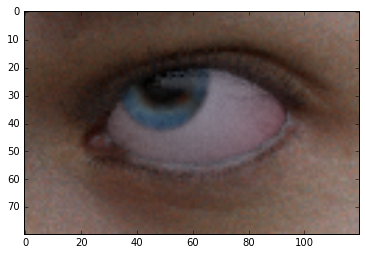

In [87]:
path= './data/f01/f01_1002_0.1963_0.3927.png'
image, ldmks_2d, ldmks_3d, head_pose, look_vec = load_image(path)

plt.imshow(image)
plt.show()